# HW4

Download dataset and plot some images

In [53]:
import os
os.environ['KAGGLE_USERNAME']='tygercat'
os.environ['KAGGLE_KEY']='80af252d9da1ccee58b0a0d195e70f09'
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [54]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

Archive:  chest-xray-pneumonia.zip
replace chest_xray.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
replace chest_xray/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: chest_xray/.DS_Store    
replace __MACOSX/chest_xray/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/chest_xray/._.DS_Store  
replace chest_xray/test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace chest_xray/test/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: chest_xray/test/.DS_Store  
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNE

In [0]:
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [0]:
img = mpimg.imread('chest_xray/train/NORMAL/IM-0115-0001.jpeg')

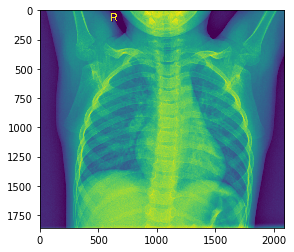

In [58]:
imgplot = plt.imshow(img)

In [0]:
def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == max_images:
        break
      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1

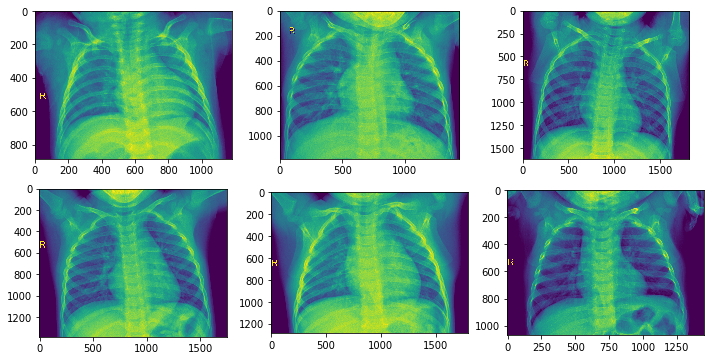

In [60]:
plot_images('chest_xray/train/NORMAL')

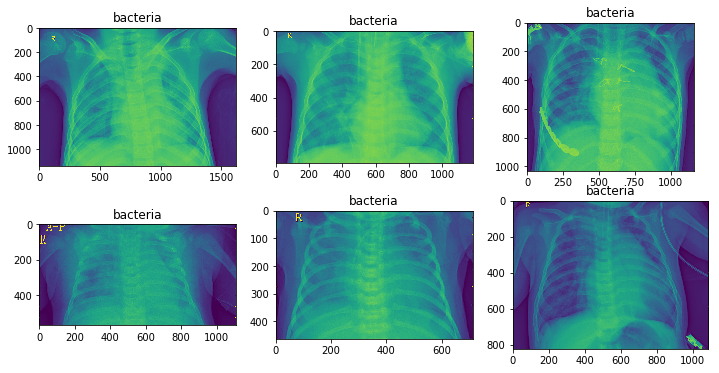

In [61]:
plot_images('chest_xray/train/PNEUMONIA', labeled=True)

Import InceptionV3 model and take a look at it

In [0]:
from keras.applications import InceptionV3

conv_base = InceptionV3(include_top=False)

In [63]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

Extracting features using conv base:

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [0]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [0]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 3, 3, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [67]:
train_features, train_labels = extract_features(train_dir, 5216)
validation_features, validation_labels = extract_features(validation_dir, 16)
test_features, test_labels = extract_features(test_dir, 624)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Flatten extracted features:

In [0]:
train_features = np.reshape(train_features, (5216, 3 * 3 * 2048))
validation_features = np.reshape(validation_features, (16, 3 * 3 * 2048))
test_features = np.reshape(test_features, (624, 3 * 3 * 2048))

Define densely connected classifier. Train on data and labels.

In [0]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_dim=3 * 3 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

In [71]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 7s 1ms/step - loss: 0.3432 - acc: 0.9057 - val_loss: 0.3923 - val_acc: 0.8750
Epoch 2/30
5216/5216 [==============================] - 4s 771us/step - loss: 0.1785 - acc: 0.9448 - val_loss: 0.4785 - val_acc: 0.8125
Epoch 3/30
5216/5216 [==============================] - 4s 769us/step - loss: 0.1508 - acc: 0.9572 - val_loss: 0.8922 - val_acc: 0.7500
Epoch 4/30
5216/5216 [==============================] - 4s 768us/step - loss: 0.1397 - acc: 0.9594 - val_loss: 0.6335 - val_acc: 0.8125
Epoch 5/30
5216/5216 [==============================] - 4s 776us/step - loss: 0.1234 - acc: 0.9638 - val_loss: 0.5741 - val_acc: 0.8750
Epoch 6/30
5216/5216 [==============================] - 4s 777us/step - loss: 0.1096 - acc: 0.9674 - val_loss: 1.1520 - val_acc: 0.6875
Epoch 7/30
5216/5216 [==============================] - 4s 770us/step - loss: 0.1033 - acc: 0.9724 - val_loss: 0.3951 - val_acc: 0.9375
Epoc

In [73]:
model.predict(validation_features)

array([[1.0000000e+00],
       [1.0000000e+00],
       [9.9997920e-01],
       [1.0000000e+00],
       [9.4101608e-01],
       [7.3123753e-01],
       [1.0000000e+00],
       [9.9924672e-01],
       [1.0000000e+00],
       [8.6426735e-07],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.0000000e+00],
       [1.0680258e-02],
       [4.3670842e-01]], dtype=float32)

In [74]:
validation_labels

array([1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.])

In [72]:
model.predict(test_features)

array([[1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.20995045e-02],
       [1.00000000e+00],
       [8.94539356e-01],
       [1.00000000e+00],
       [9.99999881e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99982417e-01],
       [1.00000000e+00],
       [9.94349718e-02],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99999642e-01],
       [1.00000000e+00],
       [9.99940574e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.96747613e-03],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [0.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
